# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [20]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [21]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [22]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9672 / 11441 MB available


In [23]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;

//Pseudocode
//c[j][i] = a[j][i] + b[j][i]
unsigned int k = j*cols + i;

c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


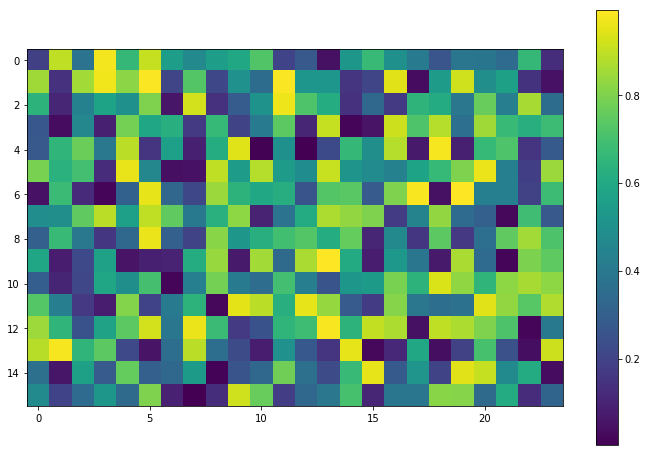

In [24]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()

In [25]:
print(a.shape)

(16, 24)


In [26]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [27]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [36]:
#a.shape = [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0])
block_size = (8, 4, 1) #These need to be [x,y,z]
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (24, 16)
Block size is (8, 4, 1)
Grid size is (3, 4, 1)


In [37]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.1435065 , 1.3815482 , 0.5593269 , 1.4317756 , 1.0279362 ,
        1.2108588 , 1.2064086 , 0.6896701 , 0.73531425, 1.209055  ,
        1.0205739 , 0.65370846, 1.1099075 , 0.82087773, 1.0538864 ,
        0.97043616, 1.3603867 , 1.0559335 , 0.818009  , 0.5449143 ,
        1.1970663 , 0.81288624, 0.89512527, 0.9191284 ],
       [1.4053857 , 0.8744831 , 1.2753432 , 1.4466269 , 0.8470668 ,
        1.6113328 , 0.77195805, 1.3361084 , 0.62177104, 1.0544357 ,
        0.8876651 , 1.6911538 , 1.3621072 , 1.2514096 , 0.46288368,
        0.8984585 , 1.5048239 , 0.05496078, 0.64149463, 1.0729934 ,
        1.4620335 , 1.1332368 , 0.5494485 , 1.009643  ],
       [1.2053753 , 0.5695564 , 1.3730165 , 1.4380615 , 0.95759445,
        1.7369938 , 0.35504025, 1.0350652 , 0.40009052, 0.6716997 ,
        1.1002274 , 1.0949286 , 1.5945591 , 1.2010696 , 1.0188566 ,
        0.8005712 , 1.0434023 , 1.3830609 , 0.7513201 , 0.4852447 ,
        1.3029376 , 0.6431646 , 1.3319293 , 0.52837276],
       [1.003

In [38]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.1435065  1.3815482  0.5593269  1.4317756  1.0279362  1.2108588
  1.2064086  0.6896701  0.73531425 1.209055   1.0205739  0.65370846
  1.1099075  0.82087773 1.0538864  0.97043616 1.3603867  1.0559335
  0.818009   0.5449143  1.1970663  0.81288624 0.89512527 0.9191284 ]
 [1.4053857  0.8744831  1.2753432  1.4466269  0.8470668  1.6113328
  0.77195805 1.3361084  0.62177104 1.0544357  0.8876651  1.6911538
  1.3621072  1.2514096  0.46288368 0.8984585  1.5048239  0.05496078
  0.64149463 1.0729934  1.4620335  1.1332368  0.5494485  1.009643  ]
 [1.2053753  0.5695564  1.3730165  1.4380615  0.95759445 1.7369938
  0.35504025 1.0350652  0.40009052 0.6716997  1.1002274  1.0949286
  1.5945591  1.2010696  1.0188566  0.8005712  1.0434023  1.3830609
  0.7513201  0.4852447  1.3029376  0.6431646  1.3319293  0.52837276]
 [1.0035319  0.11656962 1.4152565  0.29809606 1.2760181  0.9757253
  1.4950684  0.89031994 0.8107158  0.80691445 0.88441694 1.1770309
  0.56564116 1.140156   0.8396869  0.79695016 1

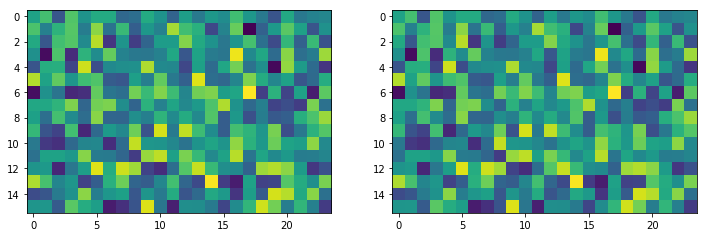

In [39]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)